In [5]:
!pip install segmentation_models rembg pillow

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [7]:
import os 
import keras
import numpy as np 
from tqdm import tqdm 
import tensorflow as tf


# Data 
import scipy.ndimage as mp
from glob import glob
import pathlib
import cv2 as cv
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.image import resize
import tensorflow.image as tfi

# Model prepare
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split

# Data visualization
import matplotlib.pyplot as plt

#from rembg import remove
from PIL import Image

import subprocess
from IPython.display import FileLink, display

from keras.utils import  Sequence


In [8]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as smp;

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [9]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [10]:
# создание ссылок на изображения и маски
img = sorted(glob(r'../input/aisegmentcom-matting-human-datasets/clip_img/*/*/*'))
mask = sorted(glob(r'../input/aisegmentcom-matting-human-datasets/matting/*/*/*'))

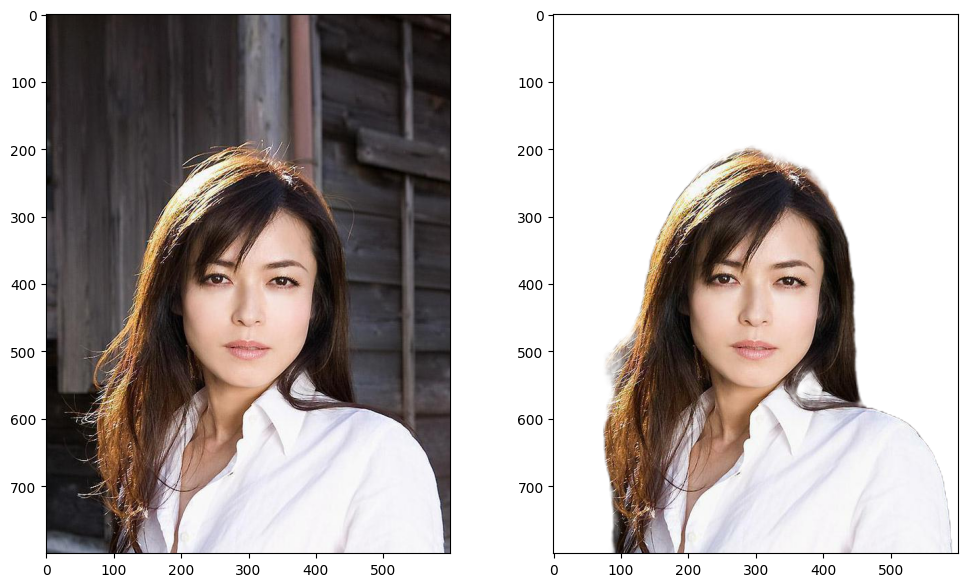

In [11]:
plt.figure(figsize=(12, 7))
plt.subplot(1,2,1)
im = plt.imread(img[99])
plt.imshow(im)
plt.subplot(1,2,2)
m = plt.imread(mask[99])
plt.imshow(m)
plt.show()

## Создание загрузчика данных, который использует не всю оперативную память а освобождает ее по ходу обучения

In [40]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, images, labels, batch_size=32, workers=1, use_multiprocessing=False, max_queue_size=None, dim=(224,224,3), shuffle=True):
        
        super().__init__(workers, use_multiprocessing, max_queue_size)  #**kwargs)
        
        self.use_multiprocessing = use_multiprocessing
        self.workers = workers
        self.max_queue_size = max_queue_size
        
        self.dim = dim
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end() # 

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.images[i])
            img  = tf.image.resize(img,[self.dim[0],self.dim[1]],method='lanczos5')
            img = img_to_array(img)/255.
            batch_imgs.append(img)
            #Store class
            label = load_img(self.labels[i])
            label = tf.image.resize(label,[self.dim[0],self.dim[1]],method='lanczos5') # interpolation doesen't have lanczos5

            label = img_to_array(label)[:,:,0]
            label = label != 0
            label = mp.binary_erosion(mp.binary_erosion(label))
            label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)

In [70]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


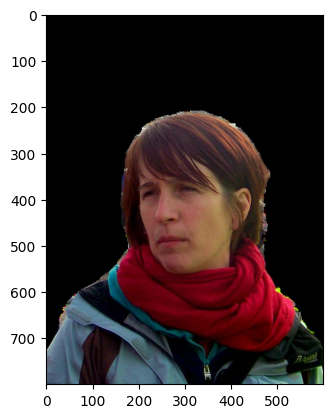

In [82]:
label1 = load_img(mask[27241])
plt.imshow(label1)
label1 = tf.image.resize(label1,[244,244],method=tf.image.ResizeMethod.LANCZOS5)

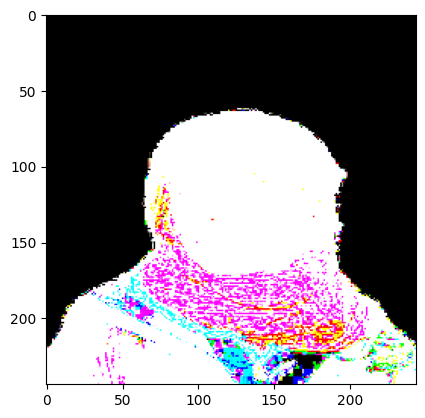

In [83]:
plt.imshow(label1)

## Визуализация обучения

In [41]:
def ShowImage(image, title=None, cmap=None):
    #возвращает изображение из входа матрицы
    plt.imshow(image, cmap=cmap)
    if title is not None : plt.title(title)
    plt.axis('off')
    
class ShowProgress(Callback):
    def __init__(self, valid):
        self.valid = valid
        
    
    def on_epoch_end(self, epoch, logs):
        
        plt.figure(figsize=(15,8))
        #i = np.random.randint(valid.batch_size-1)
        
        img = valid[0][0][0:3] # так как метод предикт принимает только от 2х и более картинок
        pred_mask = self.model.predict(img)[0] #[i-1]
        
        pred_mask = np.array(pred_mask, dtype="uint8").reshape(224,224)
        mapping = cv.bitwise_and(img[0],img[0],mask=pred_mask)#[0]  i-2 i-2

        plt.subplot(1,4,1)
        ShowImage(img[0],title="Исходное изображение")
    
        plt.subplot(1,4,2)
        ShowImage(pred_mask, title="Предсказаная маска")
    
        plt.subplot(1,4,3)
        ShowImage(valid[0][1][0].reshape(224, 224), title="Истиная маска")
    
        plt.subplot(1,4,4)
        ShowImage(mapping, title="Наложеная Маска")
    
        plt.tight_layout()
        plt.show()

In [42]:
X_train, X_test, y_train, y_test = train_test_split(img, mask, test_size=0.30, random_state=44)

In [43]:
generator = DataGenerator(X_train, y_train, batch_size=32, dim=(224,224,3),shuffle=True)
valid = DataGenerator(X_test ,y_test, batch_size=32, dim=(224,224,3), shuffle=True)

## Обучение

In [44]:
callback = [EarlyStopping(
    monitor='IoU', #
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=30
), ShowProgress(valid)]
# рання остановка при равенстве валидационного лоса лосу тренировочных данных

In [33]:
BACKBONE = 'efficientnetb0'
segmodel = smp.FPN(backbone_name = BACKBONE, classes=1, activation='relu',encoder_weights ='imagenet')

Epoch 1/40


I0000 00:00:1734367432.648011     108 service.cc:145] XLA service 0x7a1c30001850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734367432.648072     108 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734367432.648076     108 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-12-16 16:44:43.272486: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng2{k2=1,k3=0} for conv (f32[32,512,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,112,112]{3,2,1,0}, f32[128,512,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-16 16:44:43.403794: E external

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/stepep - IoU: 0.4404 - accuracy: 0.9461 - loss: 0.43


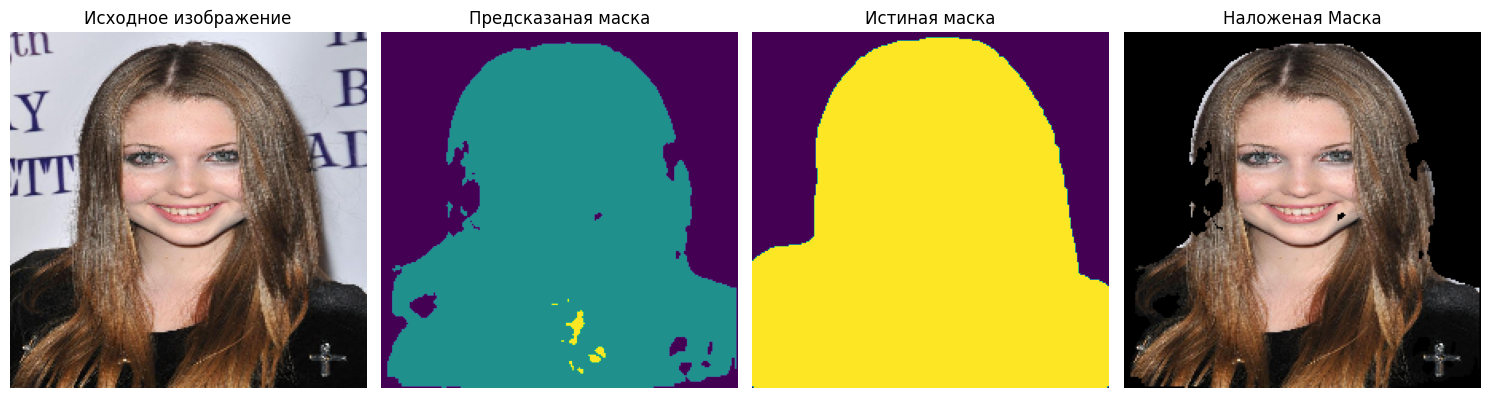

753/753 ━━━━━━━━━━━━━━━━━━━━ 2664s 3s/step - IoU: 0.4403 - accuracy: 0.9462 - loss: 0.4313 - val_IoU: 0.5553 - val_accuracy: 0.9740 - val_loss: 0.1122
Epoch 2/40
211/753 ━━━━━━━━━━━━━━━━━━━━ 18:42 2s/step - IoU: 0.8072 - accuracy: 0.9748 - loss: 0.1057

KeyboardInterrupt: 

In [45]:
segmodel.compile(optimizer="nadam", loss="binary_crossentropy", metrics = [tf.keras.metrics.BinaryIoU(target_class_ids=[1], name="IoU"), 'accuracy'])
epochs = 40
hist = segmodel.fit(generator, epochs=epochs, batch_size=32, callbacks=[callback], validation_data=valid)

## Провекрка метрик на валидационой и тестовой выборке

In [16]:
res_val = segmodel.evaluate(valid)

322/322 ━━━━━━━━━━━━━━━━━━━━ 261s 810ms/step - IoU: 0.7205 - accuracy: 0.9722 - loss: 0.0961


In [17]:
res_test = segmodel.evaluate(generator)

753/753 ━━━━━━━━━━━━━━━━━━━━ 594s 788ms/step - IoU: 0.5827 - accuracy: 0.9763 - loss: 0.0652


## Графики Метрик и Лосов

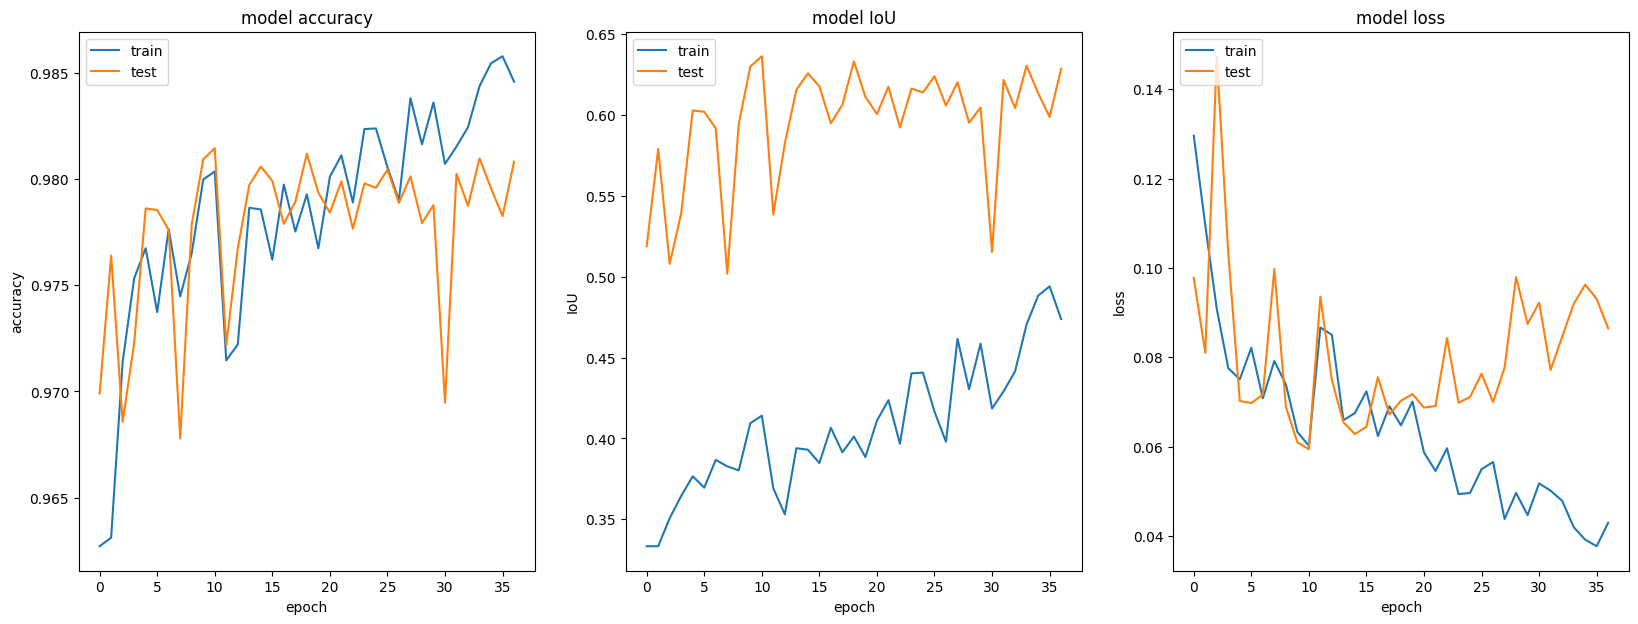

In [18]:
plt.figure(figsize=(20, 7))
plt.subplot(1,3,1)

# summarize history for accuracy
plt.subplot(1,3,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,3,2)
plt.plot(hist.history['IoU'])
plt.plot(hist.history['val_IoU'])

plt.title('model IoU')
plt.ylabel('IoU')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,3,3)
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

## VS rembg

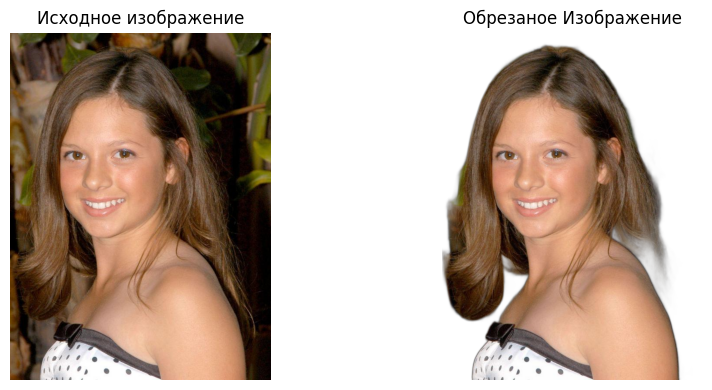

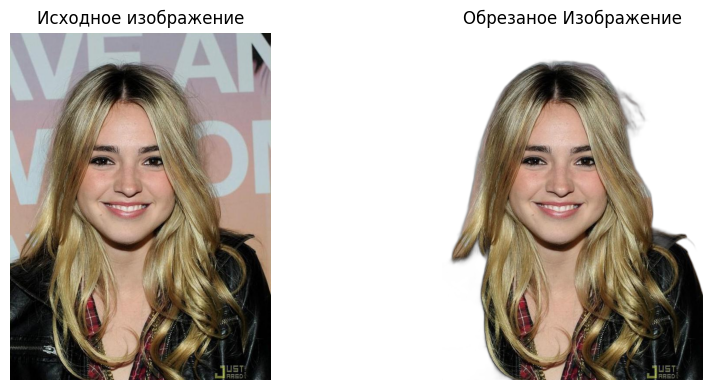

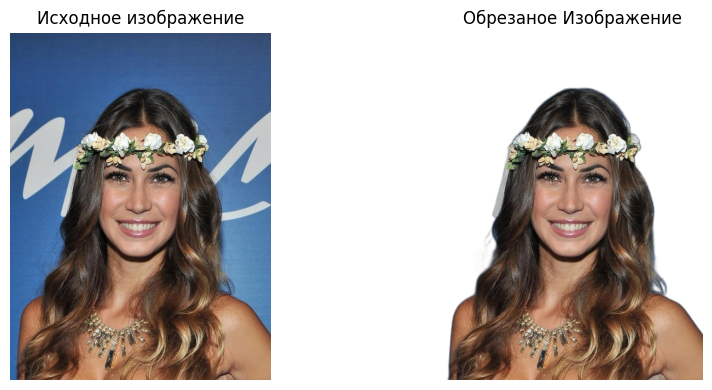

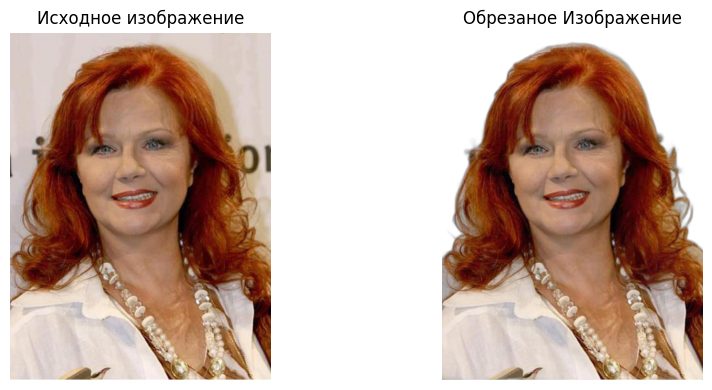

In [12]:
for el in img[:4]:
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    ShowImage(plt.imread(el),title="Исходное изображение")
    
    output_path = "out.png"
    input_1 = Image.open(el)
    output = remove(input_1)
    plt.subplot(1,2,2)
    ShowImage(output, title="Обрезаное Изображение")
    

    plt.tight_layout()
    plt.show()
    

In [14]:
valid_mini = DataGenerator(X_test[0:9] ,y_test[0:9], batch_size=7, dim=(224,224,3))
mini_pred = segmodel.predict(valid_mini)

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step


I0000 00:00:1725616563.963866     143 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


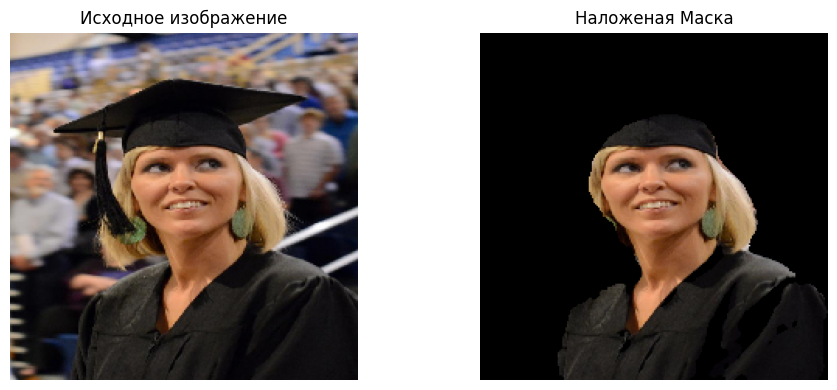

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


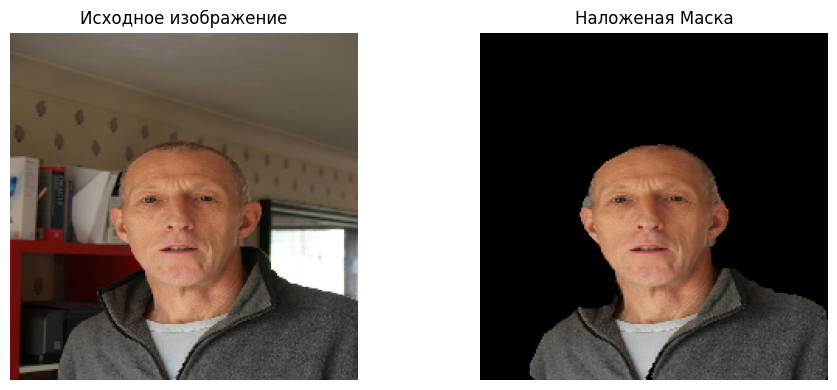

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


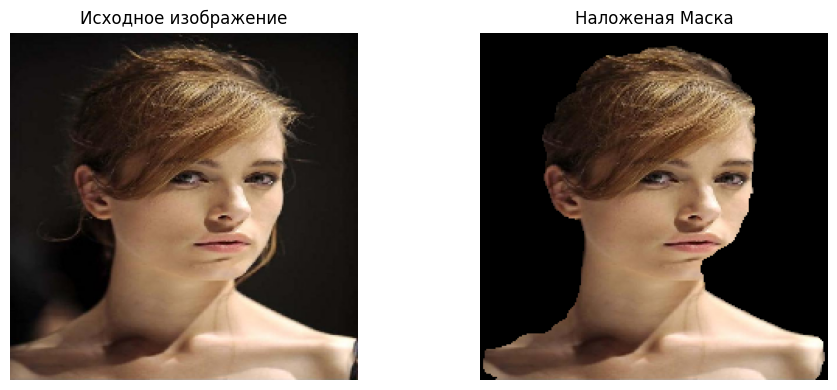

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


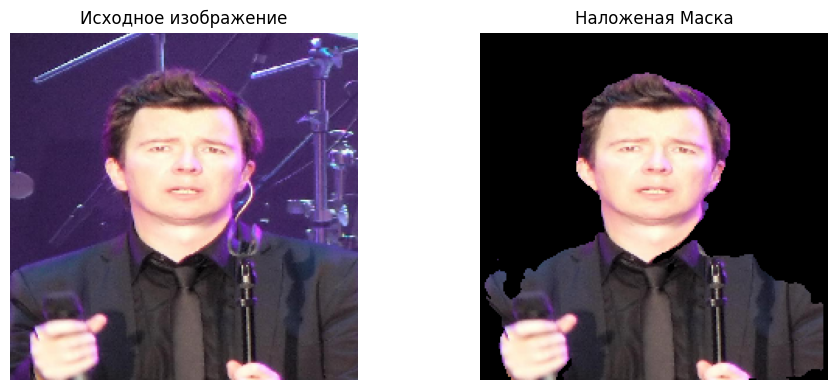

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


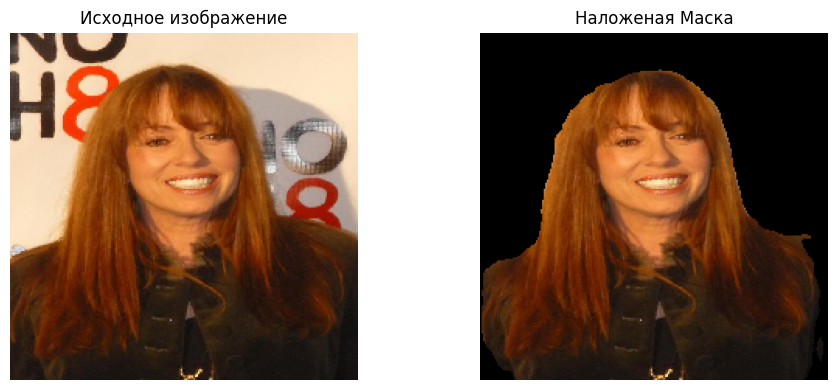

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


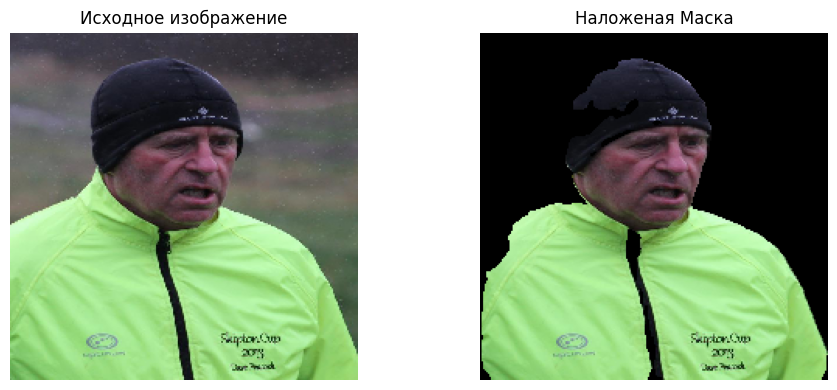

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


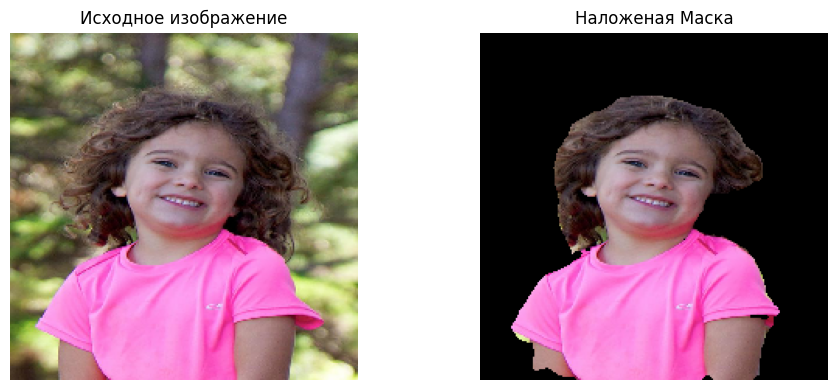

In [16]:
for i in range(len(mini_pred)):
    plt.figure(figsize=(10,4))
    img = valid_mini[0][0][0:7] # так как метод предикт принимает только от 2х и более картинок
    pred_mask = segmodel.predict(img)[i] #[i-1]
        
    pred_mask = np.array(pred_mask, dtype="uint8").reshape(224,224)
    mapping = cv.bitwise_and(img[i],img[i],mask=pred_mask)#[0]  i-2 i-2

    plt.subplot(1,2,1)
    ShowImage(img[i],title="Исходное изображение")
    
    plt.subplot(1,2,2)
    ShowImage(mapping, title="Наложеная Маска")
    
    plt.tight_layout()
    plt.show()

## Сохранение модели

In [95]:
segmodel.save('/kaggle/models/segmodel.h5')

In [66]:
download_file('/kaggle/working/', 'bg_hum_model_v2_5_efb0_24e_2_14.h5')

/kaggle/working/bg_hum_model_v2_5_efb0_24e_2_14.h5.zip

In [272]:
segmodel.save('/kaggle/models/models/segmodel.h5')